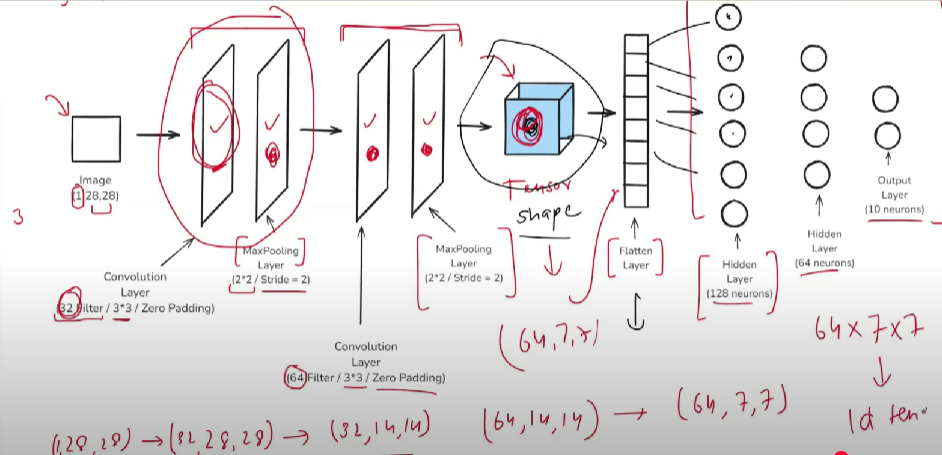

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [ ]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.shape

(60000, 785)

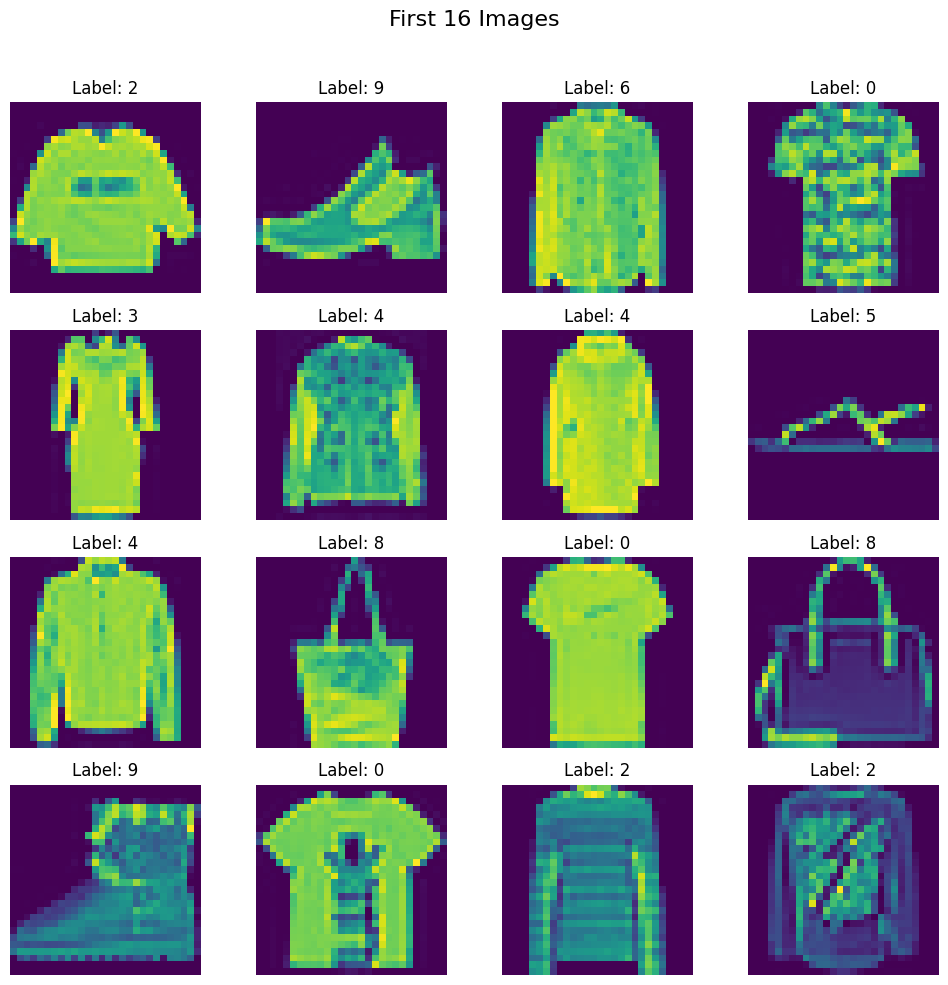

In [ ]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [ ]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [ ]:
train_dataset = CustomDataset(X_train, y_train)

In [ ]:
test_dataset = CustomDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [3]:
## CNN is has two parts : 1. Feature Extraction (Convolution and pooling part) 2. Classification (flatten nn part)

# Kernal_size in Conv2d: It slides over the input image, performing convolution (dot product between kernel and the input patch).Extract features like edges, textures, etc.
# Kernal_size in MaxPool2d: Downsample the feature map → reduces spatial size, computation, and overfitting.

class MyNN(nn.Module):
    def __init__(self, input_features):  #input_features(channel) for our case its 1 for RGB its 3
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),   # 32 : no of filters (out channel) , kernal_size : dim of filter
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),  # stride:the number of pixels the filter (or kernel) shifts over the input image during the convolution operation

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),  # 64 : no of filters (out channel) 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [ ]:
learning_rate = 0.01
epochs = 100

In [ ]:
model = MyNN(1)

model.to(device)  # Move model to GPU if available

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [ ]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.6453862568239371
Epoch: 2 , Loss: 0.3853350347826878
Epoch: 3 , Loss: 0.3277895573725303
Epoch: 4 , Loss: 0.2910455600147446
Epoch: 5 , Loss: 0.26584738612671693
Epoch: 6 , Loss: 0.24534948088601233
Epoch: 7 , Loss: 0.23220543542131783
Epoch: 8 , Loss: 0.2125600410240392
Epoch: 9 , Loss: 0.2010805631323407
Epoch: 10 , Loss: 0.18964320418424904
Epoch: 11 , Loss: 0.17589199120551346
Epoch: 12 , Loss: 0.16750397524175545
Epoch: 13 , Loss: 0.15720769087194156
Epoch: 14 , Loss: 0.1477578816814348
Epoch: 15 , Loss: 0.1417700887490064
Epoch: 16 , Loss: 0.13155867633223534
Epoch: 17 , Loss: 0.12582617242758473
Epoch: 18 , Loss: 0.12384307197310651
Epoch: 19 , Loss: 0.1120170808567976
Epoch: 20 , Loss: 0.10686964762761879
Epoch: 21 , Loss: 0.10389302656892688
Epoch: 22 , Loss: 0.09883728925433631
Epoch: 23 , Loss: 0.09389438007667195
Epoch: 24 , Loss: 0.08582745347831709
Epoch: 25 , Loss: 0.08213186161313206
Epoch: 26 , Loss: 0.07940747573083111
Epoch: 27 , Loss: 0.0805213475

In [ ]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9261666666666667


In [ ]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9999375
